In [1]:
#import related libraries
import numpy as np
import IPython
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema, find_peaks, savgol_filter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
#import dataset
data_path = "dataset/covid_19_data.csv"
dataset = pd.read_csv(data_path)
data_path = "dataset/population.csv"
population = pd.read_csv(data_path)
countrys=dataset["Country/Region"].unique()
countrys.sort()

#Start visualisation 
country_selection=ipywidgets.Dropdown(
    options=countrys,
    value='Turkey',
    description='Country:',
    disabled=False
)
graph_selection=ipywidgets.RadioButtons(
    options=['Change', 'Cummulative'],
    value='Cummulative',
    description='Graphic:',
    disabled=False
)
perpop_selection=ipywidgets.RadioButtons(
    options=['Case Per Population', 'Case Counts'],
    #value='Cummulative',
    description='Prop.?:',
    disabled=False
)

data_selection=ipywidgets.RadioButtons(
    options=['Deaths', 'Recovered', 'Confirmed', 'Active'],
    value='Active',
    description='Case:',
    disabled=False
)
plot_button=ipywidgets.Button(
    description='Plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Generate Graph via Selections',
    icon='info'
)

output = ipywidgets.Output()
def on_button_clicked(b):
    IPython.display.clear_output()
    display(country_selection, graph_selection, data_selection, perpop_selection,plot_button, output)
    with output:
        selected_country=dataset.loc[dataset["Country/Region"]==country_selection.value]
        if graph_selection.value == "Cummulative":
                plot_data = selected_country[data_selection.value]
        else:
                plot_data = selected_country[data_selection.value].diff()
        if perpop_selection.value == "Case Per Population":
            plot_data=plot_data / population[population["country"]==country_selection.value].population.iloc[0]
    sns.lineplot(y=plot_data,x=selected_country["Days"],label=country_selection.value+data_selection.value+graph_selection.value)  
    plt.show()
plot_button.on_click(on_button_clicked)


/home/emre/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# insert stage of epidemic column and Peak Day Column
def stage_edidemic(country):
    x = dataset.loc[dataset["Country/Region"]==country].Active.values
    #plt.plot(x,color='red')
    if x.size>51:
        x = savgol_filter(x, 51, 3)
    peaks, _ = find_peaks(x, height=(x.max()/2,x.max()),distance=50)
    #plt.plot(x)
    if peaks.size != 0 :
        dataset.loc[dataset["Country/Region"]==country,"Peak Day"]=dataset.loc[dataset["Country/Region"]==country].Days.values[peaks[0]]
    if peaks.shape[0] == 0:
        dataset.loc[dataset["Country/Region"]==country,"Stage"]="Begin"
    else:
        dataset.loc[dataset["Country/Region"]==country,"Stage"]=str(peaks.shape[0])+". Cycle"
    out=peaks.shape[0]
    #plt.plot(peaks, x[peaks], "x")
    #plt.plot(np.zeros_like(x), "--", color="gray")
    #plt.show()
for c in dataset["Country/Region"].unique():
    stage_edidemic(c)

In [3]:
# insert Total Confirmed/Deaths Per 1M Population column
for c in dataset["Country/Region"].unique():
    dataset.loc[dataset["Country/Region"]==c,"Total Confirmed Per 1M Population"] = dataset.loc[dataset["Country/Region"]==c]["Confirmed"].iloc[-1]*1000000/population[population["country"]==c].population.iloc[0]
    dataset.loc[dataset["Country/Region"]==c,"Total Deaths Per Population 1M"] = dataset.loc[dataset["Country/Region"]==c]["Deaths"].iloc[-1]*1000000/population[population["country"]==c].population.iloc[0]

d = { 'Total Confirmed Per 1M Population': dataset.drop_duplicates("Country/Region")["Total Confirmed Per 1M Population"],'Total Deaths Per Population 1M':dataset.drop_duplicates("Country/Region")["Total Deaths Per Population 1M"]}
dataset2 = pd.DataFrame(data=d)
for c in population.loc[population.population<1000000].country:
    dataset2=dataset2.loc[dataset["Country/Region"]!=c]
    dataset2=dataset2.loc[dataset["Total Confirmed Per 1M Population"]!=0]
    dataset2=dataset2.loc[dataset["Total Deaths Per Population 1M"]!=0]

In [4]:
#Kernel Density Estimation for classifying Total Confirmed/Deaths Per 1M Population 
def KDE(col,b):
    ds2= dataset2.sort_values(by=col)
    x=dataset2[col].values
    y=int(ds2[col].iloc[:-2].describe().max())
    #b=int(dataset2[col].mean()/2)
    #print("y:",y,"b:",b)
    a = x.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=b).fit(a)
    s = np.linspace(0,y,y)
    e = kde.score_samples(s.reshape(-1,1))
    #print("e:",e)
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    #print ("Minima:", s[mi])
    #print ("Maxima:", s[ma])
    #print (a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])
    plt.plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
         s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
         s[mi[1]:], e[mi[1]:], 'b',
         s[ma], e[ma], 'go',
         s[mi], e[mi], 'ro')
    return a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]] # low mid high


KDE of Total Deaths Per Population 1M


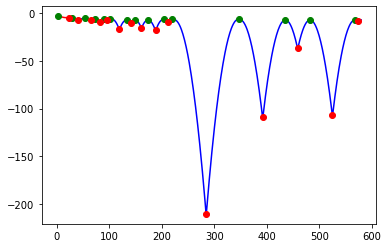

In [5]:
print("KDE of Total Deaths Per Population 1M")
low,mid,high = KDE("Total Deaths Per Population 1M",int(dataset2["Total Deaths Per Population 1M"].mean()/20))#b=int(dataset2[col].mean())
for c in low:
    dataset.loc[dataset["Total Deaths Per Population 1M"]==c,"Death State"]="Low"
for c in mid:
    dataset.loc[dataset["Total Deaths Per Population 1M"]==c,"Death State"]="Mid"
for c in high:
    dataset.loc[dataset["Total Deaths Per Population 1M"]==c,"Death State"]="High"


KDE of Total Confirmed Per Population 1M


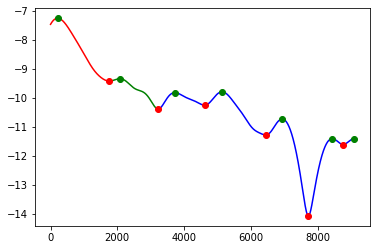

In [6]:
print("KDE of Total Confirmed Per Population 1M")
low,mid,high = KDE("Total Confirmed Per 1M Population",int(dataset2["Total Confirmed Per 1M Population"].mean()/6))#b=int(dataset2[col].mean())
for c in low:
    dataset.loc[dataset["Total Confirmed Per 1M Population"]==c,"Conf. State"]="Low"
for c in mid:
    dataset.loc[dataset["Total Confirmed Per 1M Population"]==c,"Conf. State"]="Mid"
for c in high:
    dataset.loc[dataset["Total Confirmed Per 1M Population"]==c,"Conf. State"]="High"


In [7]:
display(country_selection, graph_selection, data_selection, perpop_selection,plot_button, output)

Dropdown(description='Country:', index=163, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua …

RadioButtons(description='Graphic:', index=1, options=('Change', 'Cummulative'), value='Cummulative')

RadioButtons(description='Case:', index=3, options=('Deaths', 'Recovered', 'Confirmed', 'Active'), value='Acti…

RadioButtons(description='Prop.?:', options=('Case Per Population', 'Case Counts'), value='Case Per Population…

Button(description='Plot', icon='info', style=ButtonStyle(), tooltip='Generate Graph via Selections')

Output()

In [8]:
#########Result##############
country_sel=ipywidgets.Dropdown(
    options=countrys,
    value='Turkey',
    description='Country:',
    disabled=False
)
classificate=ipywidgets.RadioButtons(
    options=['Stage', 'Peak Day', 'Death State', 'Conf. State'],
    value='Stage',
    description='Classification:',
    disabled=False
)
result=ipywidgets.Button(
    description='Result',
    disabled=False,
    button_style='',
    icon='info'
)
output2 = ipywidgets.Output()
def on_button_clicked2(b):
    IPython.display.clear_output()
    display(country_sel, classificate, result, output2)
    country=dataset.loc[dataset["Country/Region"]==country_sel.value]
    cls= country[classificate.value]
    
    IPython.display.display(str(classificate.value)+" of "+country_sel.value+" is "+str(cls.iloc[0]))
    IPython.display.display("Countries they have same: "+classificate.value+" with "+country_sel.value+";")
    samecountries=dataset.loc[dataset[classificate.value]==cls.iloc[0]]["Country/Region"].unique()
    IPython.display.display(samecountries)
    IPython.display.display(dataset.loc[dataset[classificate.value]==dataset.loc[dataset["Country/Region"]==country_sel.value][classificate.value].values[0]].drop_duplicates("Country/Region"))
    
result.on_click(on_button_clicked2)

In [9]:
display(country_sel, classificate, result, output2)


Dropdown(description='Country:', index=163, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua …

RadioButtons(description='Classification:', options=('Stage', 'Peak Day', 'Death State', 'Conf. State'), value…

Button(description='Result', icon='info', style=ButtonStyle())

Output()

'Stage of Turkey is 1. Cycle'

'Countries they have same: Stage with Turkey;'

array(['Hong Kong', 'Thailand', 'South Korea', 'Singapore', 'Malaysia',
       'Vietnam', 'Cambodia', 'Sri Lanka', 'Finland',
       'United Arab Emirates', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia',
       'Switzerland', 'Georgia', 'Norway', 'Romania', 'Estonia',
       'San Marino', 'Belarus', 'Iceland', 'Lithuania', 'New Zealand',
       'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador',
       'Czech Republic', 'Dominican Republic', 'Portugal', 'Andorra',
       'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal', 'Jordan',
       'Hungary', 'Liechtenstein', 'Tunisia', 'Bosnia and Herzegovina',
       'Slovenia', 'Costa Rica', 'Serbia', 'Slovakia', 'Togo', 'Malta',
       'Bulgaria', 'Maldives', 'Paraguay', 'Albania', 'Cyprus', 'Brunei',
       'Burkina Faso', 'Holy See', 'Mongolia', 'Panama', 'Jamaica',
       'Turkey', 'Cuba', 'Guyana', 'Kazakhstan', 'Sudan', 'Guinea',
       'Antigua and Barbuda', 'Uruguay', 'Namibia', 'Seychelles',
       'Trinidad and Tobago', 'Eswatini', 'Rwan

,SNo,ObservationDate,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active,First,Days,Peak Day,Stage,Total Confirmed Per 1M Population,Total Deaths Per Population 1M,Death State,Conf. State
0,13,01/22/2020,Hong Kong,1/22/2020 17:00,0.0,0.0,0.0,0.0,01/22/2020,1,79.0,1. Cycle,147.926212,0.533548,Low,Low
1,37,01/22/2020,Thailand,1/22/2020 17:00,2.0,0.0,0.0,2.0,01/22/2020,1,76.0,1. Cycle,44.914054,0.830946,Low,Low
2,38,01/22/2020,South Korea,1/22/2020 17:00,1.0,0.0,0.0,1.0,01/22/2020,1,55.0,1. Cycle,236.418816,5.402856,Low,Low
6,77,01/23/2020,Singapore,1/23/20 17:00,1.0,0.0,0.0,1.0,01/23/2020,1,111.0,1. Cycle,6940.448952,4.444185,Low,High
8,79,01/23/2020,Malaysia,1/23/20 17:00,0.0,0.0,0.0,0.0,01/23/2020,1,79.0,1. Cycle,261.169136,3.738491,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16475,2013,02/21/2020,Lebanon,2020-02-21T15:33:03,1.0,0.0,0.0,1.0,02/21/2020,1,72.0,1. Cycle,211.854319,4.688339,Low,Low
16590,1,01/22/2020,Mainland China,1/22/2020 17:00,547.0,17.0,28.0,502.0,01/22/2020,1,30.0,1. Cycle,57.492263,3.202885,Low,Low
17164,483,01/31/2020,Russia,1/31/2020 23:59,2.0,0.0,0.0,2.0,01/31/2020,1,128.0,1. Cycle,3619.892058,47.541889,High,High
17300,552,02/01/2020,Spain,2/1/2020 2:13,1.0,0.0,0.0,1.0,02/01/2020,1,76.0,1. Cycle,5217.178018,580.389880,High,High
